# Introduction to mempyDEB


This notebook is a walkthrough of the basic functionality of the `mempyDEB`. <br>
It will show you how to load the package, run a simulation, modify parameters and plot results.

## Notebook-Setup

First we load a bunch of Python packages. <br>
Not all of these are always needed to run simulations, but we will use them at some point and try to load them now to make sure that they are installed. <br>
The comments indicate what each package is good for.

In [1]:
import numpy as np # fast numeric computation (e.g. matrix algebra)
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # statistical plotting functions
pal = sns.color_palette() # color palette used for plots
from scipy import stats # basic statistical functions
import pandas as pd # dataframes like in R
from copy import copy # copying stu ff
import os # os and sys deal with system-related things, such as walking directories
import sys # 
import pprint # pretty printing
pp = pprint.PrettyPrinter(indent=2) # settings to print pretty
from tqdm import tqdm # progress bar

current_dir = os.path.dirname(os.path.abspath('')) # this saves the directory of the executed file as variable 
project_directory = os.path.dirname(current_dir) # this saves the project directory as variable (might be above current_dir)

Now we can load some content from the mempyDEB package:

In [2]:
from mempyDEB.DEBODE.simulators import * # functions to run models
from mempyDEB.DEBODE.defaultparams import * # some default parameter configurations

ImportError: attempted relative import with no known parent package

In [3]:
EMB_DEV_TIME = 2 # this is a constant, it will be useful later

In [8]:
import mempyDEB

In [12]:
defaultparams_DEBBase

NameError: name 'defaultparams_DEBBase' is not defined

## First simulation: Running the default parameters

By loading `defaultparams`, we have made the following objects available:

In [4]:
glb # global parameters. the general simulation settings like simulated timespan, food input rate etc.

{'tspan': (0, 23), 'a_int': 2, 'V_patch': 0.05, 'Xdot_in': 375, 'C_W': 0.0}

In [5]:
spc # species-specific parameters (DEB and TKTD)

{'Idot_max_rel': 4,
 'Idot_max_rel_emb': 4,
 'eta_IA': 0.35,
 'K_X': 500.0,
 'kappa': 0.9,
 'eta_AS': 0.9,
 'eta_SA': 0.9,
 'eta_AR': 0.95,
 'k_M': 0.4,
 'S_p': 9,
 'X_emb_int': 0.675,
 'kD_j': 0.5,
 'ED50_j': 1.0,
 'beta_j': 2.0,
 'pmoa': 'G',
 'kD_h': 0.5,
 'ED50_h': 2.0,
 'beta_h': 1.0}

No we can run the `DEBBase` model like so:

In [6]:
yhat = simulate_DEBBase((glb, spc));

Note that in the call to `simulate_DEBBase`, the argument is a tuple containing `glb` and `spc`, hence the double parentheses.

What we get out is a `pd.DataFrame` object with the major state variables over time:

In [7]:
yhat.head()

,S,R,X_emb,X,D_j,D_h,t,survival
0,0.000010,0.0,0.675000,375.000000,0.0,0.0,-2,1.0
1,0.052863,0.0,0.470145,375.000000,0.0,0.0,-1,1.0
2,0.314846,0.0,-0.000007,546.505365,0.0,0.0,0,1.0
3,0.850989,0.0,-0.000007,918.905466,0.0,0.0,1,1.0
4,1.679842,0.0,-0.000007,1289.404861,0.0,0.0,2,1.0


An easy way to plot this is with `seaborn`, which nicely works with `pd.DataFrame`.

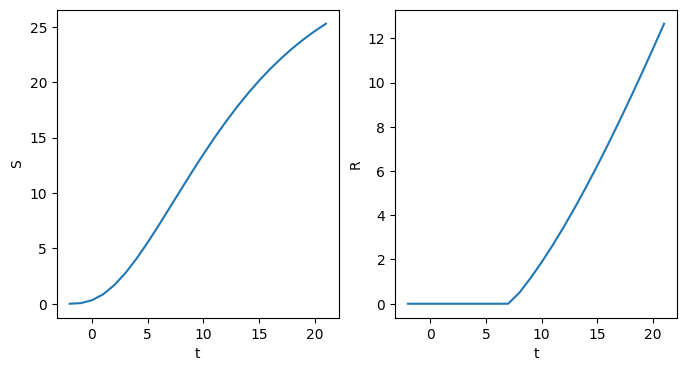

In [13]:
fig, ax = plt.subplots(ncols = 2, figsize = (8,4)) # creates a subplot with 3 columns

for (i,var) in enumerate(["S", "R"]): # for each of these variables
    sns.lineplot(yhat, x = "t", y = var, ax = ax[i]) # plot it over time and place it on the ith subplot

## Modifying parameters

Once we start to modify parameters, a good place to start is to create a copy of the default parameters:

In [15]:
pglb = glb.copy()
pscp = spc.copy()

Now we can play with `pglb` and `pscp` without affecting the default. <br>
Below we iterate over several values of `kappa`:

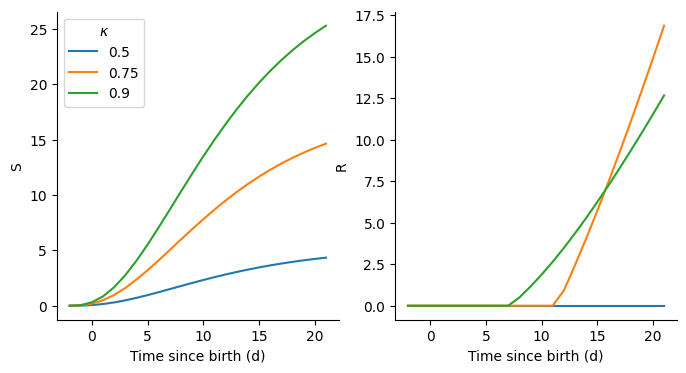

In [37]:
fig, ax = plt.subplots(ncols = 2, figsize = (8,4)) # creates a subplot with 3 columns

for kap in [0.5, 0.75, 0.9]:

    pscp["kappa"] = kap

    yhat = simulate_DEBBase((pglb, pscp))

    for (i,var) in enumerate(["S", "R"]): # for each of these variables
        sns.lineplot(yhat, x = "t", y = var, ax = ax[i], label = kap); # plot it over time and place it on the ith subplot

ax[0].legend(title = r"$\kappa$") # add a legend title
ax[1].legend().remove() # remove legend for second subplot

# prettying up the plot a little
sns.despine() # this removes the boundary boxes
[a.set(xlabel = "Time since birth (d)") for a in ax];

## Erste Simulation von Chemikalien-Effekten

Zur Simulation von Chemikalieneffekten nutzen wir wieder die Funktion `run_ODE_constantexposures` mit den Argumenten `glb` (globale Parameter), `anm` (animal-Parameter) und `C_Wvec` (Vektor von Expositionskonzentrationen). <br>
Expositionskonzentrationen werden in toxikolgischen Experimenten häufigentsprechend einer geometrischen Folge definiert:

In [5]:
C_Wvec = np.round(np.append([0], np.geomspace(0.01 ,10 , num = 5)), decimals = 2)
anm['X_emb_int'] = 0.3

Die TKTD-Parameter müssen außerdem gegeben sein:

In [6]:
anm['kD_j']  = 0.5 # toxikokinetische Rantekonstante
anm['ED50_j'] = 1. # median effective damage
anm['beta_j'] = 1. # Hill's-Slope

In [7]:
simout = run_ODE_constantexposures(
    glb, anm, C_Wvec 
).groupby('C_W').apply(
            lambda gb : gb.assign(cum_repro = np.trunc(gb.R / anm['X_emb_int']).shift(EMB_DEV_TIME, fill_value = 0))
            ).drop(['C_W'], axis = 1).reset_index()

ref = simout.loc[simout.C_W == 0] # Referenz-Werte (Kontrollle)

simout.head()

,C_W,level_1,S,R,X_emb,X,D_j,D_h,t_day,survival,cum_repro
0,0.0,0,0.000010,0.0,0.300000,375.000000,0.0,0.0,-2,1.0,0.0
1,0.0,1,0.052865,0.0,0.095135,375.000000,0.0,0.0,-1,1.0,0.0
2,0.0,2,0.307650,0.0,-0.000011,693.285289,0.0,0.0,0,1.0,0.0
3,0.0,3,0.843892,0.0,-0.000011,1065.694231,0.0,0.0,1,1.0,0.0
4,0.0,4,1.673833,0.0,-0.000011,1436.198199,0.0,0.0,2,1.0,0.0


Welcher Physiological Mode of Action (PMoA) wurde bei der obigen Simulation angenommen? Wie ist dieser zu interpretieren?

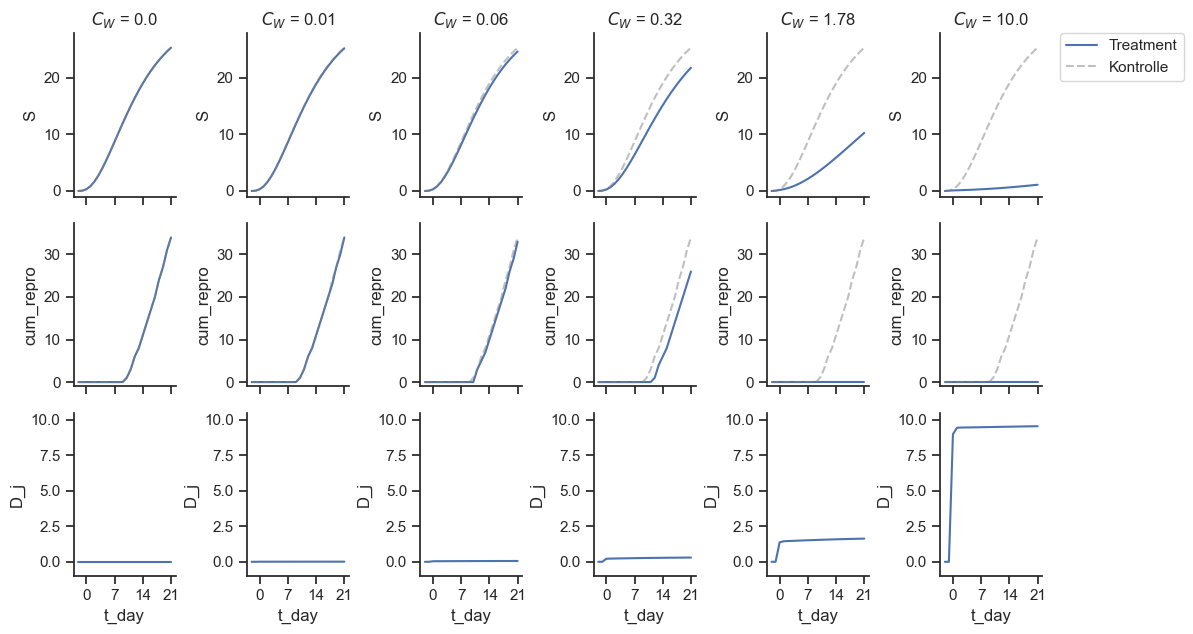

In [8]:
fig, ax = plt.subplots(ncols = len(C_Wvec), nrows = 3, figsize = (12,6.5), sharex = True)

for (i,C_W) in enumerate(simout.C_W.unique()): # für jede Konzentration
    df = simout.loc[lambda df : df.C_W == C_W] # simulations-output für lediglich diese Konzentration
    sns.lineplot(df, x = 't', y = 'S', ax = ax[0,i], label = "Treatment") # plotte Wachstum in entsprechender Spalte
    sns.lineplot(df, x = 't', y = 'cum_repro', ax = ax[1,i]) # plotte Reproduktion in entsprechender Spalte

    sns.lineplot(ref, x = 't', y = 'S', linestyle = '--', color = 'gray', alpha = 0.5, ax = ax[0,i], label = "Kontrolle")
    sns.lineplot(ref, x = 't', y = 'cum_repro', linestyle = '--', color = 'gray', alpha = 0.5, ax = ax[1,i])

    sns.lineplot(df, x = 't', y = 'D_j', ax = ax[2,i])

    # plotten der referenz (Kontrolle)
    ax[0,i].set(ylim = (-1, np.max(simout.S) * 1.1), title = f'$C_W$ = {C_W}') # setzen der y-Achsenlimits für Wachstum
    ax[1,i].set(ylim = (-1, np.max(simout.cum_repro) * 1.1)) # setzen der y-Achsenlimits für Reproduktion
    ax[2,i].set(ylim = (-1, np.max(simout.D_j) * 1.1)) # für Damage

[ax[0,i].legend().remove() for i in range(5)]
ax[0,5].legend(bbox_to_anchor=(1.1, 1.05))
ax[0,0].set_xticks(np.arange(0,22,step=7))
sns.despine()
plt.tight_layout()

### Berechnung der relative Response

Um die Daten zu skalieren und die Effekte besser zu erkennen ist die relative Response `y` nützlich. Hierbei handelt sich um den Wert eines jeweiligen Endpunkts (hier `S` oder `cum_repro`), geteilt durch den entsprechenden Wert in der Kontrolle zum selben Zeitpunkt. <br>

In [9]:
simout = pd.merge(
    simout, 
    ref[['t', 'C_W', 'S', 'R', 'cum_repro']],
    on = ['t'],
    suffixes = ['', '_ref']
    )
simout.head()

,C_W,level_1,S,R,X_emb,X,D_j,D_h,t_day,survival,cum_repro,C_W_ref,S_ref,R_ref,cum_repro_ref
0,0.00,0,0.00001,0.0,0.3,375.0,0.0,0.0,-2,1.0,0.0,0.0,0.00001,0.0,0.0
1,0.01,0,0.00001,0.0,0.3,375.0,0.0,0.0,-2,1.0,0.0,0.0,0.00001,0.0,0.0
2,0.06,0,0.00001,0.0,0.3,375.0,0.0,0.0,-2,1.0,0.0,0.0,0.00001,0.0,0.0
3,0.32,0,0.00001,0.0,0.3,375.0,0.0,0.0,-2,1.0,0.0,0.0,0.00001,0.0,0.0
4,1.78,0,0.00001,0.0,0.3,375.0,0.0,0.0,-2,1.0,0.0,0.0,0.00001,0.0,0.0


In [10]:
def calc_y(x, x_cntr):
    assert len(x)==1, 'arguments to calc_y should contain exactly one element - missing grouping variable?'

    if x_cntr.iloc[0] == 0:
        return 1
    else:
        return x.iloc[0] / x_cntr.iloc[0]

responses = simout.groupby(['C_W', 't']).apply(lambda df : pd.DataFrame({
    'y_S' : [calc_y(df.S, df.S_ref)],
    'y_cum_repro' : [calc_y(df.cum_repro, df.cum_repro_ref)],
    'y_R' : [calc_y(df.R, df.R_ref)]
})).reset_index()

responses

simout = pd.merge(simout, responses, on = ['t', 'C_W'])

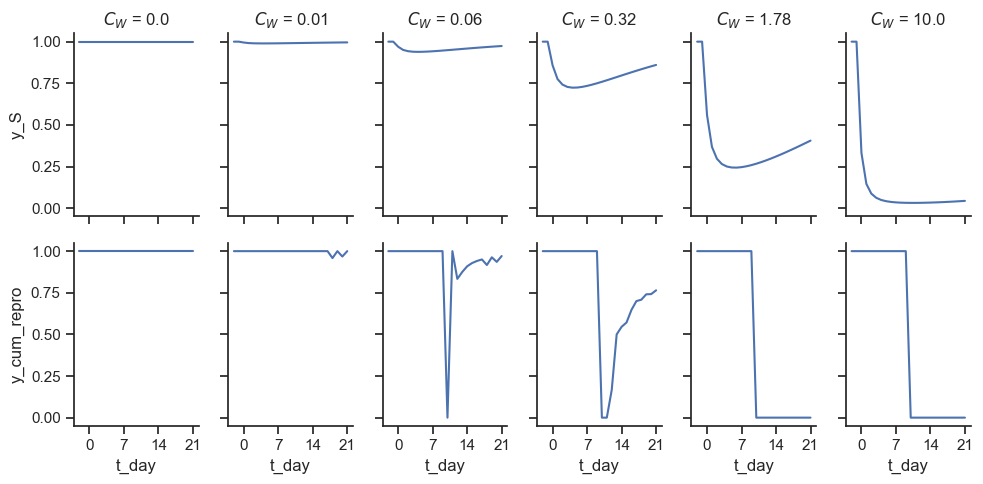

In [11]:
fig, ax = plt.subplots(ncols = len(responses.C_W.unique()), nrows = 2, figsize = (10,5), sharex = True, sharey = True)

for (i,C_W) in enumerate(responses.C_W.unique()): # für jede Konzentration
    df = responses.loc[lambda df : df.C_W == C_W] # simulations-output für lediglich diese Konzentration
    sns.lineplot(df, x = 't', y = 'y_S', ax = ax[0,i]) # plotte Wachstum in entsprechender Spalte
    sns.lineplot(df, x = 't', y = 'y_cum_repro', ax = ax[1,i]) # plotte Reproduktion in entsprechender Spalte
    ax[0,i].set(title = f'$C_W$ = {C_W}')
    
ax[0,0].set_xticks(np.arange(0,22,step=7))
sns.despine()
plt.tight_layout()

Fällt Ihnen an den geplotteten relative Responses irgendetwas auf? Verlgeichen Sie die relativen Responses mit den zuvor geplotteten absoluten Werten. Wie könnten unerwartete Effekte zustande kommen?

## Simulation unterschiedlicher PMoAs

Es macht für den weiteren Verlauf Sinn, die bisherigen Schritte in eine einzelne Funktion zu packen (Ausführen der Simulation, Berechnung der kumulativen Reproduktion mit shiften und Berechnung der relative response)

In [12]:
def simulate_exposures(glb, anm, C_Wvec):
    # Ausführen der Simulation
    simout = run_ODE_constantexposures(
        glb, anm, C_Wvec 
        ).groupby('C_W').apply(
            lambda gb : gb.assign(cum_repro = np.trunc(gb.R / anm['X_emb_int']).shift(EMB_DEV_TIME, fill_value = 0))
            ).drop(['C_W'], axis = 1).reset_index()

    ref = simout.loc[simout.C_W == 0] # Referenz-Werte (Kontrollle)

    # füge Referenz-Werte als neue Spalte hinzu
    simout = pd.merge(
        simout, 
        ref[['t', 'C_W', 'S', 'R', 'cum_repro']],
        on = ['t'],
        suffixes = ['', '_ref']
    )

    # berechne relative responses für jede Konzentration und jeden Zeitpunkt
    responses = simout.groupby(['C_W', 't']).apply(lambda df : pd.DataFrame({
        'y_S' : [calc_y(df.S, df.S_ref)],
        'y_cum_repro' : [calc_y(df.cum_repro, df.cum_repro_ref)],
        'y_R' : [calc_y(df.R, df.R_ref)]
    })).reset_index()

    # kombiniere relative responses mit abosulten werten
    simout = pd.merge(simout, responses, on = ['t', 'C_W'])

    return simout

In [13]:
simout = simulate_exposures(glb, anm, C_Wvec)
simout.head()

,C_W,level_1,S,R,X_emb,X,D_j,D_h,t_day,survival,cum_repro,C_W_ref,S_ref,R_ref,cum_repro_ref,level_2,y_S,y_cum_repro,y_R
0,0.00,0,0.00001,0.0,0.3,375.0,0.0,0.0,-2,1.0,0.0,0.0,0.00001,0.0,0.0,0,1.0,1.0,1.0
1,0.01,0,0.00001,0.0,0.3,375.0,0.0,0.0,-2,1.0,0.0,0.0,0.00001,0.0,0.0,0,1.0,1.0,1.0
2,0.06,0,0.00001,0.0,0.3,375.0,0.0,0.0,-2,1.0,0.0,0.0,0.00001,0.0,0.0,0,1.0,1.0,1.0
3,0.32,0,0.00001,0.0,0.3,375.0,0.0,0.0,-2,1.0,0.0,0.0,0.00001,0.0,0.0,0,1.0,1.0,1.0
4,1.78,0,0.00001,0.0,0.3,375.0,0.0,0.0,-2,1.0,0.0,0.0,0.00001,0.0,0.0,0,1.0,1.0,1.0


Wiederholen Sie die Simulation für alle vier PMoAs und plotten Sie die vorhergesagten Zeitreihen (Plot mit Subplots wie oben, einzelne Linie für jeden PMoA). Sammen Sie alle Ergebnisse im DataFrame `simout_all_pmoas`. <br>
Tipp: Mit der pandas-Funktion pd.concat wird aus einer liste von DataFrames ein einzelnern DataFrame. Nutzen Sie die pandas-Methode assign um den Ergebnissen eine Spalte für den simulerten PMoA hinzuzufügen.

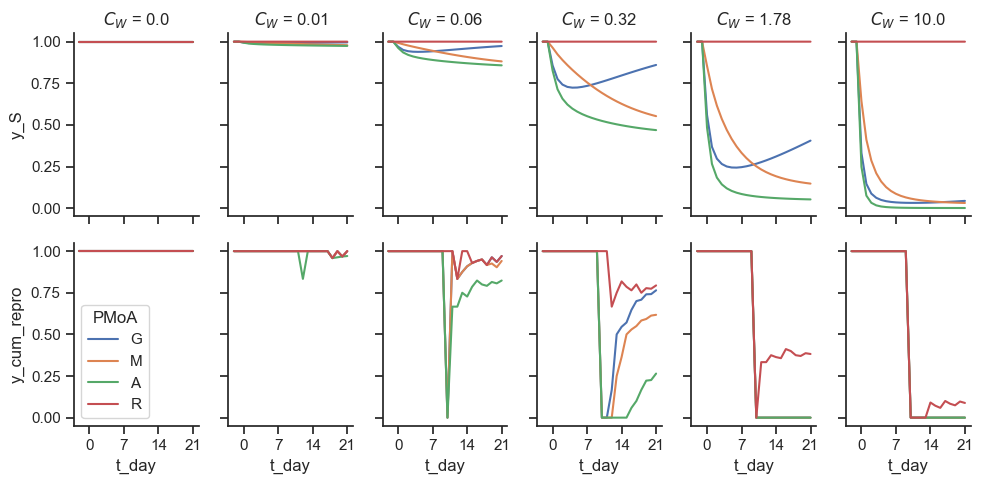

In [14]:
simout_all_pmoas = pd.DataFrame()

fig, ax = plt.subplots(ncols = len(responses.C_W.unique()), nrows = 2, figsize = (10,5), sharex = True, sharey = True)


for pmoa in ['G', 'M', 'A', 'R']:
    anm_j = anm.copy()
    anm_j['pmoa']  = pmoa
    simout = simulate_exposures(glb, anm_j, C_Wvec).assign(pmoa = pmoa)
    simout_all_pmoas = pd.concat([simout_all_pmoas, simout])

    for (i,C_W) in enumerate(simout.C_W.unique()): # für jede Konzentration
        df = simout.loc[lambda df : df.C_W == C_W] # simulations-output für lediglich diese Konzentration
        sns.lineplot(df, x = 't', y = 'y_S', ax = ax[0,i]) # plotte Wachstum in entsprechender Spalte
        sns.lineplot(df, x = 't', y = 'y_cum_repro', ax = ax[1,i], label = pmoa) # plotte Reproduktion in entsprechender Spalte
        ax[0,i].set(title = f'$C_W$ = {C_W}')

        if i>0:
            ax[1,i].legend().remove()
        
ax[1,0].legend(title = "PMoA")
ax[0,0].set_xticks(np.arange(0,22,step=7))
sns.despine()
plt.tight_layout()

Plotten Sie für jeden PMoA die Konzentrations-Wirkungs-Beziehung für die kumulative Reproduktion am letzten Zeitpunkt. <br>

Vergleichen Sie den EC50 für kumulative Reproduktion für verschiedene PMoAs mit dem $ED50_j$ (1 für alle PMoAs).

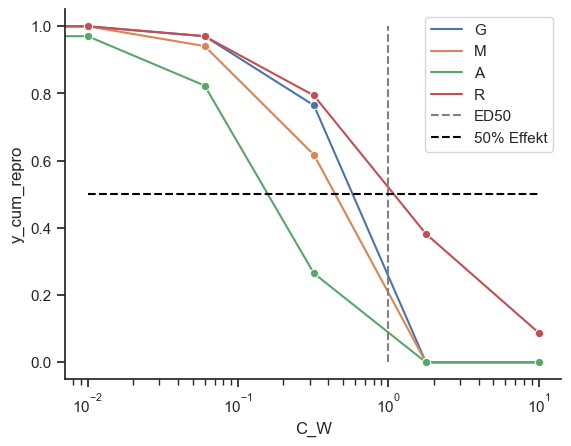

In [15]:
end = simout_all_pmoas.loc[lambda df : df.t==np.max(df.t)]

fig = plt.figure()
ax = fig.gca()

sns.lineplot(end, x = 'C_W', y = 'y_cum_repro', hue = 'pmoa', marker = 'o')

ax.set(xscale = 'log')
ax.vlines([1], ymin = 0, ymax = 1, color = 'gray', linestyle = '--', label = 'ED50')
ax.hlines([0.5], xmin=0.01, xmax = 10, color = 'black', linestyle = '--', label = '50% Effekt')

plt.legend()
sns.despine()

Generieren Sie obige Abbildung für verschiedene Werte von $\beta_j$. Ändert sich das Verhältnis zwischen ED50 und EC50 für alle / manche PMoAs?

C:\Users\shansul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\shansul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\shansul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


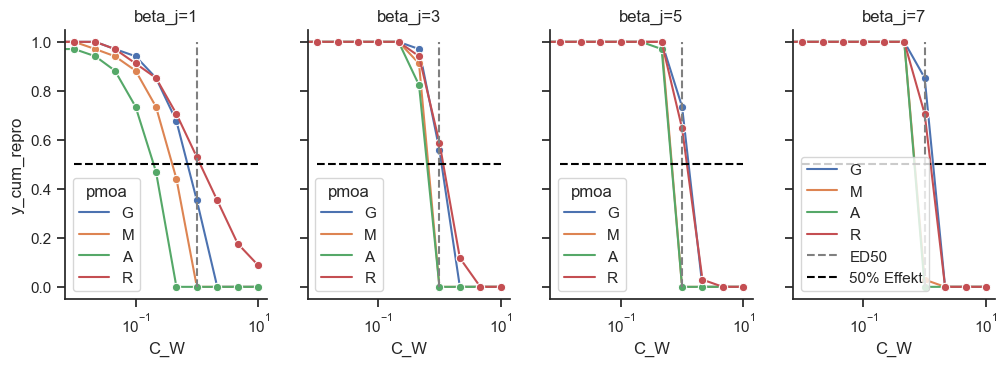

In [24]:
simout_all_pmoas = pd.DataFrame()

fig, ax = plt.subplots(ncols = 4, nrows = 1, figsize = (12,3.5), sharex = True, sharey = True)

for (i,beta) in enumerate([1, 3, 5, 7]):
    simout_all_pmoas = pd.DataFrame()

    for pmoa in ['G', 'M', 'A', 'R']:
        anm_j = anm.copy()
        anm_j['pmoa']  = pmoa
        anm_j['beta_j'] = beta
        # es kann nützlich sein C_Wvec zu ersetzen und mehr Konzentrationen zu simulieren
        simout = simulate_exposures(glb, anm_j, np.round(np.append([0], np.geomspace(0.01 ,10 , num = 10)), decimals = 3)).assign(pmoa = pmoa)
        simout_all_pmoas = pd.concat([simout_all_pmoas, simout])

        end = simout_all_pmoas.loc[lambda df : df.t==np.max(df.t)]
    
    sns.lineplot(end.loc[end.C_W>0], x = 'C_W', y = 'y_cum_repro', hue = 'pmoa', marker = 'o', ax= ax[i])

    ax[i].set(xscale = 'log', title = f"beta_j={beta}")
    ax[i].vlines([1], ymin = 0, ymax = 1, color = 'gray', linestyle = '--', label = 'ED50')
    ax[i].hlines([0.5], xmin=0.01, xmax = 10, color = 'black', linestyle = '--', label = '50% Effekt')

ax[3].legend()
sns.despine()  

## Beispielkalibrierung für synthetischen Datensatz

In [25]:
trueparams = anm.copy()
trueparams['ED50_j'] = 0.5
trueparams['beta_j'] = 0.8
trueparams['pmoa'] = 'R'

data = simulate_exposures(glb, trueparams, C_Wvec)
data.to_csv('data/Uebung5_toxdata.csv')

In [26]:
data = pd.read_csv("data/Uebung5_toxdata.csv")
data.head()

,Unnamed: 0,C_W,level_1,S,R,X_emb,X,D_j,D_h,t_day,survival,cum_repro,C_W_ref,S_ref,R_ref,cum_repro_ref,level_2,y_S,y_cum_repro,y_R
0,0,0.00,0,0.00001,0.0,0.3,375.0,0.0,0.0,-2,1.0,0.0,0.0,0.00001,0.0,0.0,0,1.0,1.0,1.0
1,1,0.01,0,0.00001,0.0,0.3,375.0,0.0,0.0,-2,1.0,0.0,0.0,0.00001,0.0,0.0,0,1.0,1.0,1.0
2,2,0.06,0,0.00001,0.0,0.3,375.0,0.0,0.0,-2,1.0,0.0,0.0,0.00001,0.0,0.0,0,1.0,1.0,1.0
3,3,0.32,0,0.00001,0.0,0.3,375.0,0.0,0.0,-2,1.0,0.0,0.0,0.00001,0.0,0.0,0,1.0,1.0,1.0
4,4,1.78,0,0.00001,0.0,0.3,375.0,0.0,0.0,-2,1.0,0.0,0.0,0.00001,0.0,0.0,0,1.0,1.0,1.0


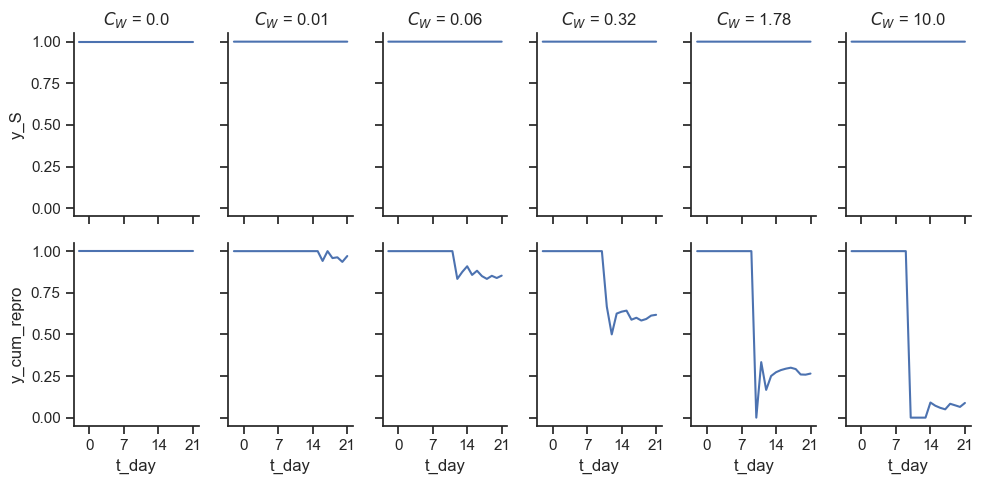

In [27]:
fig, ax = plt.subplots(ncols = len(data.C_W.unique()), nrows = 2, figsize = (10,5), sharex = True, sharey = True)

for (i,C_W) in enumerate(data.C_W.unique()): # für jede Konzentration
    df = data.loc[lambda df : df.C_W == C_W] # simulations-output für lediglich diese Konzentration
    sns.lineplot(df, x = 't', y = 'y_S', ax = ax[0,i]) # plotte Wachstum in entsprechender Spalte
    sns.lineplot(df, x = 't', y = 'y_cum_repro', ax = ax[1,i]) # plotte Reproduktion in entsprechender Spalte
    ax[0,i].set(title = f'$C_W$ = {C_W}')
    
ax[0,0].set_xticks(np.arange(0,22,step=7))
sns.despine()
plt.tight_layout()

## Definition priors

In [28]:
logclosest = np.log(np.array([0.32, 1.78]))
logmean = np.mean(logclosest)
priormean_ED50 = np.exp(logmean)

In [29]:
priors = {
    'k_Dj' : deftruncnorm(0.5, 1, 0, np.inf),
    'ED50_j' : deftruncnorm(priormean_ED50, 1, 0, np.inf),
    'beta_j' : deftruncnorm(2, 1, 0, np.inf)
}

In [30]:
def simulator(theta: dict) -> tuple: # theta = rand(priors_tox)

    anm_params = anm.copy()

    for (param,value) in theta.items():
        anm_params[param] = value

    # ausführung der simulation
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        prediction = run_ODE_constantexposures(glb, anm_params, C_Wvec)
        prediction = prediction.groupby(['C_W']).apply(
            lambda gb : gb.assign(cum_repro = np.trunc(gb.R / anm_params['X_emb_int']).shift(EMB_DEV_TIME, fill_value = 0))
            )

        ### berechnung der relativen response
        ref = prediction.loc[prediction.C_W == 0]
        prediction = pd.merge(prediction, ref, on = ['t'], suffixes = ['', '_ref']).groupby(['t', 'C_W']).apply(
            lambda gb : pd.DataFrame({
                'y_S': [calc_y(gb.S, gb.S_ref)],
                'y_cum_repro' : [calc_y(gb.cum_repro, gb.cum_repro_ref)],
                })
        ).reset_index().fillna(1)

        return prediction

In [31]:
def distance(
        predicted: pd.DataFrame, # e.g. predicted = simulator_tox(rand(priors_tox))[1]
        observed: pd.DataFrame # e.g. observed = azoxy_tox
        ) -> float: # returns a scalar value
    """
    Calculate the distance based on time series data.
    """

    # kombinieren der Vorhersage und Beobachtung in einen einzelnen Dataframe
    eval_df = pd.merge(predicted, observed, on = ['t', 'C_W'], how = 'right', suffixes = ['_predicted', '_observed'])
    
    # Berechnung der Distanz auf Basis von Wachstumseffekten
    dist_S = np.sum((eval_df.y_S_predicted - eval_df.y_S_observed)**2)
    # Berechnung der Distanz auf Basis von Reproduktionseffekten
    dist_R = np.sum((eval_df.y_cum_repro_predicted - eval_df.y_cum_repro_observed)**2)

    # gesamtdistanz ist die mittlere Distanz pro Endpunkt
    dist = (dist_S + dist_R) / 2

    return dist

Nutzen Sie den vorgegebenen Code um die Parameterschätzung für eine geringe Anzahl Samples auszuführen (z.B. n_init = 100).

In [35]:
ABC_params = {
    'simulator' : simulator, # simulator function
    'distance' : distance, # distance function
    'priors' : priors, # prior distributions
    'data' : data, # observations
    't_max' : 0, # SMC steps (t_max = 0 == rejection-ABC)
    'n_init' : 1_00, # number of ABC samples (1000 sollte ausreichen)
    'q_eps' : 0.1, # distance threshold as quantile of distance vector
    'cv_stop' : 0.1 # 
}
abc = SMCABC(ABC_params)
accepted = abc.run()

--- Generating initial population with 100 particles ---
--- Calculating distances ---


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:14<00:00,  6.74it/s]

--- Filtering particles ---
ABC unconverged with max cv = 0.646


Sehen Sie sich den zurückgegebenen Wert `accepted` an. Extrahieren Sie das Parametersample mit der geringsten Distanz 
(Anwendung der Pandas-Methoden `loc` und `min`). Durch Anwendung von `posterior_sample` können Sie die resultierende Dataframe-Zeile in ein Dictionary überführen.

In [37]:
bstfit = posterior_sample(accepted.loc[accepted.distance == np.min(accepted.distance)])
pred = simulator(bstfit)
pred.head()

,t_day,C_W,level_2,y_S,y_cum_repro
0,-2,0.00,0,1.0,1.0
1,-2,0.01,0,1.0,1.0
2,-2,0.06,0,1.0,1.0
3,-2,0.32,0,1.0,1.0
4,-2,1.78,0,1.0,1.0


Generieren Sie die Vorhersage für das Parametersample mit der geringsten Distanz und plotten Sie die vorhergesagte relative response über die Zeit zusammen mit den beobachteten Werten. Beurteilen Sie die Anpassungsgüte.

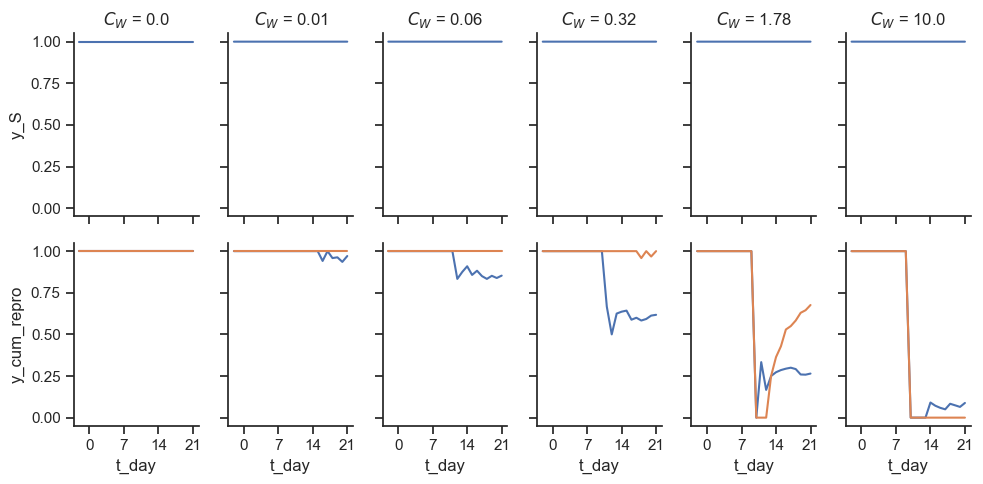

In [38]:
fig, ax = plt.subplots(ncols = len(data.C_W.unique()), nrows = 2, figsize = (10,5), sharex = True, sharey = True)

for (i,C_W) in enumerate(data.C_W.unique()): # für jede Konzentration
    df = data.loc[lambda df : df.C_W == C_W] # simulations-output für lediglich diese Konzentration
    dfpred = pred.loc[pred.C_W == C_W]
    sns.lineplot(df, x = 't', y = 'y_S', ax = ax[0,i]) # plotte Wachstum in entsprechender Spalte
    sns.lineplot(df, x = 't', y = 'y_cum_repro', ax = ax[1,i]) # plotte Reproduktion in entsprechender Spalte
    sns.lineplot(dfpred, x = 't', y = 'y_cum_repro', ax = ax[1,i])
    ax[0,i].set(title = f'$C_W$ = {C_W}')
    
ax[0,0].set_xticks(np.arange(0,22,step=7))
sns.despine()
plt.tight_layout()

## Extra-Übung

100 Samples sind sehr wahrscheinlich nicht ausreichend, um eine hohe Anpassungsgüte in allen Konzentrationen zu erreichen (und definitiv nicht ausreichend, um Wahrscheinlichkeitsverteilungen zu charakterisieren). Wiederholen Sie die Kalibrierung mit einer höheren Anzahl Samples und führen Sie den posterior predictive check durch (durch wiederholte anwendung von `posterior_sample(accepted)` und `simulator`).

In [45]:
ABC_params = {
    'simulator' : simulator, # simulator function
    'distance' : distance, # distance function
    'priors' : priors, # prior distributions
    'data' : data, # observations
    't_max' : 0, # SMC steps (t_max = 0 == rejection-ABC)
    'n_init' : 10_000, # number of ABC samples (1000 sollte ausreichen)
    'q_eps' : 0.1, # distance threshold as quantile of distance vector
    'cv_stop' : 0.1 # 
}
abc = SMCABC(ABC_params)
accepted = abc.run()

--- Generating initial population with 10000 particles ---
--- Calculating distances ---


100%|██████████| 10000/10000 [26:22<00:00,  6.32it/s]

--- Filtering particles ---
ABC unconverged with max cv = 0.616


In [46]:
# posterior predictions
pred = pd.concat([simulator(posterior_sample(accepted)).assign(n_sample = i) for i in range(100)])

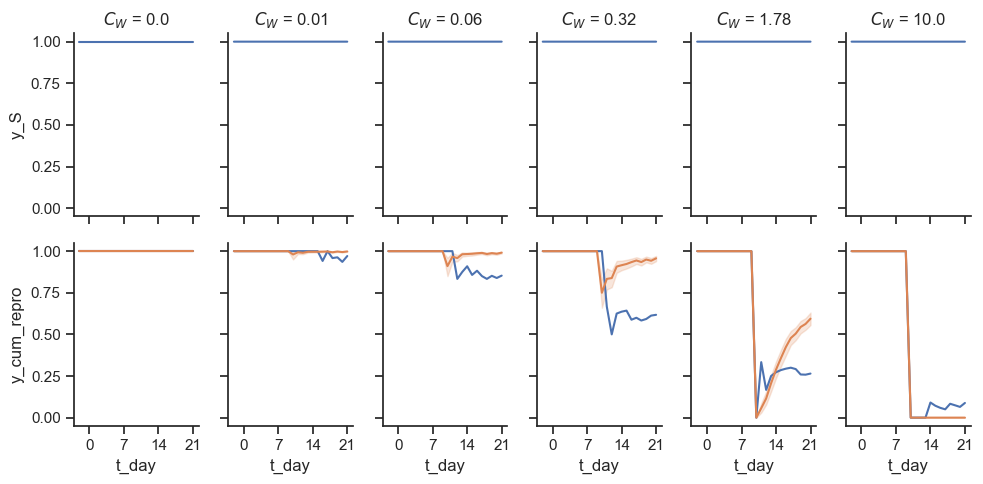

In [47]:
# visual predictive check
fig, ax = plt.subplots(ncols = len(data.C_W.unique()), nrows = 2, figsize = (10,5), sharex = True, sharey = True)

for (i,C_W) in enumerate(data.C_W.unique()): # für jede Konzentration
    df = data.loc[lambda df : df.C_W == C_W] # simulations-output für lediglich diese Konzentration
    dfpred = pred.loc[pred.C_W == C_W]
    sns.lineplot(df, x = 't', y = 'y_S', ax = ax[0,i]) # plotte Wachstum in entsprechender Spalte
    sns.lineplot(df, x = 't', y = 'y_cum_repro', ax = ax[1,i]) # plotte Reproduktion in entsprechender Spalte
    sns.lineplot(dfpred, x = 't', y = 'y_cum_repro', ax = ax[1,i])
    ax[0,i].set(title = f'$C_W$ = {C_W}')
    
ax[0,0].set_xticks(np.arange(0,22,step=7))
sns.despine()
plt.tight_layout()